In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Paths to the files
path_train_embeds = '/content/drive/My Drive/DATASET/EMB/train_embeds.npy'

# Loading the data
train_embeds = np.load(path_train_embeds)

In [ ]:

# Print the shape of the loaded data to confirm
print("Loaded data shape:", train_embeds.shape)

# converting embeddings numpy array(train_embeds) into pandas dataframe
column_num = train_embeds.shape[1]
train_df = pd.DataFrame(train_embeds, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
print(train_df.shape)

train_df.head()

Loaded data shape: (142246, 1024)
(142246, 1024)


,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,...,Column_1015,Column_1016,Column_1017,Column_1018,Column_1019,Column_1020,Column_1021,Column_1022,Column_1023,Column_1024
0,0.049488,-0.032935,0.032473,-0.033723,-0.059505,0.075936,-0.045860,-0.104476,-0.072112,0.038806,...,-0.046516,-0.028773,-0.021878,-0.097883,0.056475,0.080950,-0.020938,-0.043532,0.096463,0.073070
1,-0.044616,0.064925,-0.080263,-0.075338,-0.004731,0.025408,-0.024685,-0.016568,-0.038980,-0.033870,...,-0.040173,0.003925,0.006130,0.007362,-0.066848,0.106882,-0.030134,0.026724,0.027879,-0.048430
2,-0.020128,-0.049779,0.007894,-0.000829,-0.047737,0.086453,-0.038107,-0.036379,0.029611,0.045029,...,0.029388,0.008456,0.000697,0.013502,-0.005968,-0.011571,0.005704,-0.036103,0.007693,0.106234
3,-0.007515,0.060628,0.004045,0.027056,-0.021542,0.010380,-0.025064,-0.055834,0.068238,0.027764,...,0.020792,0.023307,0.009009,0.018211,0.020820,-0.031738,0.013279,-0.018357,0.008087,0.010917
4,0.013468,0.041516,0.018435,-0.035595,0.008770,0.018699,-0.015452,-0.038092,-0.038326,-0.012299,...,-0.044742,-0.025432,-0.060886,-0.026915,0.026342,0.017237,0.014731,-0.016861,-0.016272,0.037054


In [ ]:

# Define the path to the pickle file
pickle_path = "/content/drive/My Drive/DATASET/labels_df.pkl"

# load labels_df from the pickle file
labels_df = pd.read_pickle(pickle_path)
print("Loaded labels_df from pickle.")


# Ensure train_embeds has the shape (num_samples, sequence_length, embedding_dim)
# Adding a new axis to have shape (142246, 1024, 1)
train_embeds = np.expand_dims(train_embeds, axis=-1)

# Proceed with splitting the datasets
# First, split the data into a training set and a temporary testing set
X_train, X_temp, y_train, y_temp = train_test_split(
    train_df, labels_df, test_size=0.2, random_state=42
)

# Next, split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Display the dimensions of the sets to verify proper splitting
print(f"Training set dimensions: {X_train.shape}, {y_train.shape}")
print(f"Validation set dimensions: {X_val.shape}, {y_val.shape}")
print(f"Test set dimensions: {X_test.shape}, {y_test.shape}")


Loaded labels_df from pickle.
Training set dimensions: (113796, 1024), (113796, 1500)
Validation set dimensions: (14225, 1024), (14225, 1500)
Test set dimensions: (14225, 1024), (14225, 1500)


In [ ]:
# Verify shapes of the data
print(f"Shape of train_embeds: {train_embeds.shape}")
print(f"Shape of train_labels: {labels_df.shape}")

Shape of train_embeds: (142246, 1024, 1)
Shape of train_labels: (142246, 1500)


In [ ]:
# Constants
EMBED_DIM = 32  # Dimension of the embedding space
NUM_HEADS = 2  # Number of attention heads
FF_DIM = 64  # Dimension of the feed-forward network
BATCH_SIZE = 32
NUM_LABELS = 1500

# Transformer Encoder Layer
def transformer_encoder(inputs, embed_dim, num_heads, ff_dim, rate=0.1):
    # Multi-head attention
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
    attention_output = Dropout(rate)(attention_output)
    attention_output = LayerNormalization(epsilon=1e-6)(inputs + attention_output)

    # Feed forward network
    ffn_output = Dense(ff_dim, activation="relu")(attention_output)
    ffn_output = Dense(embed_dim)(ffn_output)
    ffn_output = Dropout(rate)(ffn_output)
    ffn_output = LayerNormalization(epsilon=1e-6)(attention_output + ffn_output)
    return ffn_output

# Transformer Encoder Layer
def transformer_encoder(inputs, embed_dim, num_heads, ff_dim, rate=0.1):
    # Multi-head attention
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
    attention_output = Dropout(rate)(attention_output)
    attention_output = LayerNormalization(epsilon=1e-6)(inputs + attention_output)

    # Feed forward network
    ffn_output = Dense(ff_dim, activation="relu")(attention_output)
    ffn_output = Dense(embed_dim)(ffn_output)
    ffn_output = Dropout(rate)(ffn_output)
    ffn_output = LayerNormalization(epsilon=1e-6)(attention_output + ffn_output)
    return ffn_output

# Transformer Model for Protein Function Prediction
def build_transformer(embed_dim, num_heads, ff_dim, num_labels, rate):
    inputs = Input(shape=(1024, 1))
    x = transformer_encoder(inputs, embed_dim, num_heads, ff_dim, rate)

    # Global average pooling and final dense layer for classification
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = Dense(num_labels, activation="sigmoid")(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Build and compile the model
model = build_transformer(EMBED_DIM, NUM_HEADS, FF_DIM, NUM_LABELS, 0.1)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Define the checkpoint callback
checkpoint_path = "/content/drive/MyDrive/model_checkpoints/transformer_model2.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1024, 1)]            0         []                            
                                                                                                  
 multi_head_attention (Mult  (None, 1024, 1)              449       ['input_1[0][0]',             
 iHeadAttention)                                                     'input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 1024, 1)              0         ['multi_head_attention[0][0]']
                                                                                                  
 tf.__operators__.add (TFOp  (None, 1024, 1)              0         ['input_1[0][0]',         

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=10,
    callbacks=[checkpoint_callback]
)

Epoch 1/10
3557/3557 [==============================] - 140s 38ms/step - loss: 0.0849 - accuracy: 0.4708 - val_loss: 0.0783 - val_accuracy: 0.6505
Epoch 2/10
   3/3557 [..............................] - ETA: 2:07 - loss: 0.0737 - accuracy: 0.6562

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3557/3557 [==============================] - 136s 38ms/step - loss: 0.0782 - accuracy: 0.4877 - val_loss: 0.0782 - val_accuracy: 0.2533
Epoch 3/10
3557/3557 [==============================] - 137s 38ms/step - loss: 0.0782 - accuracy: 0.4907 - val_loss: 0.0785 - val_accuracy: 0.6505
Epoch 4/10
3557/3557 [==============================] - 136s 38ms/step - loss: 0.0782 - accuracy: 0.4841 - val_loss: 0.0783 - val_accuracy: 0.2533
Epoch 5/10
3557/3557 [==============================] - 136s 38ms/step - loss: 0.0782 - accuracy: 0.4749 - val_loss: 0.0783 - val_accuracy: 0.6505
Epoch 6/10
3557/3557 [==============================] - 136s 38ms/step - loss: 0.0782 - accuracy: 0.4998 - val_loss: 0.0782 - val_accuracy: 0.2533
Epoch 7/10
3557/3557 [==============================] - 136s 38ms/step - loss: 0.0782 - accuracy: 0.4805 - val_loss: 0.0784 - val_accuracy: 0.6505
Epoch 8/10
3557/3557 [==============================] - 136s 38ms/step - loss: 0.0782 - accuracy: 0.4966 - val_loss: 0.0785 - val

445/445 [==============================] - 7s 15ms/step


<Figure size 800x600 with 0 Axes>

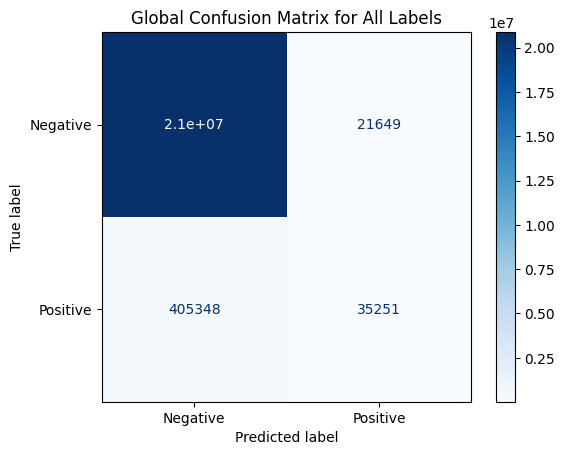

Global Confusion Matrix:
                          Predicted
               ------------------------------
               Negative     | Positive
Actual Negative    20875252        | 21649
Actual Positive    405348        | 35251


In [ ]:
# Model load from google drive
#model_path = "/content/drive/MyDrive/model_checkpoints/transformer_model_2.h5"
#model = tf.keras.models.load_model(model_path)

#NUM_LABELS = 1500

# Ensure y_test is a numpy array
if isinstance(y_test, pd.DataFrame):
    y_test = y_test.values

# Make predictions
predictions = model.predict(X_test)

# Threshold to convert probabilities to binary labels
binary_predictions = (predictions > 0.5).astype(int)  #>=0.45

# Initialize a global confusion matrix
global_confusion_matrix = np.zeros((2, 2), dtype=int)

# Calculate confusion matrices for each label and sum them
for i in range(NUM_LABELS):
    cm = confusion_matrix(y_test[:, i], binary_predictions[:, i])
    global_confusion_matrix += cm  # Add this label's matrix to the global matrix

# Display the global confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=global_confusion_matrix, display_labels=['Negative', 'Positive'])
plt.figure(figsize=(8, 6))  # Adjust the figure size if necessary
disp.plot(cmap=plt.cm.Blues)
plt.title('Global Confusion Matrix for All Labels')
plt.show()

# Print the global confusion matrix as a table
print("Global Confusion Matrix:")
print("                          Predicted")
print("               ------------------------------")
print(f"               Negative     | Positive")
print(f"Actual Negative    {global_confusion_matrix[0, 0]}        | {global_confusion_matrix[0, 1]}")
print(f"Actual Positive    {global_confusion_matrix[1, 0]}        | {global_confusion_matrix[1, 1]}")

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_curve, auc

# Ensure y_test is a numpy array
if isinstance(y_test, pd.DataFrame):
    y_test = y_test.values
if isinstance(predictions, pd.DataFrame):
    predictions = predictions.values

#Function to calculate Fmax
def calculate_fmax(precision, recall):
    fmax = 0
    for i in range(len(precision)):
        if precision[i] + recall[i] == 0:
            continue  #Avoid a division by zero
        f = (2 * precision[i] * recall[i]) / (precision[i] + recall[i])
        if f > fmax:
            fmax = f
    return fmax

#Calculate the precision-recall curve and AUPR for each label
precision = dict()
recall = dict()
aupr = dict()
for i in range(NUM_LABELS):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], predictions[:, i])
    aupr[i] = auc(recall[i], precision[i])

#Calculate the average AUPR
average_aupr = np.mean(list(aupr.values()))
print(f"Average AUPR: {average_aupr}")

# Calculate Fmax
all_precisions = np.concatenate([precision[i] for i in range(NUM_LABELS)])
all_recalls = np.concatenate([recall[i] for i in range(NUM_LABELS)])
fmax = calculate_fmax(all_precisions, all_recalls)
print(f"Fmax: {fmax}")


Average AUPR: 0.4552368075396848
Fmax: 0.7851225552993424


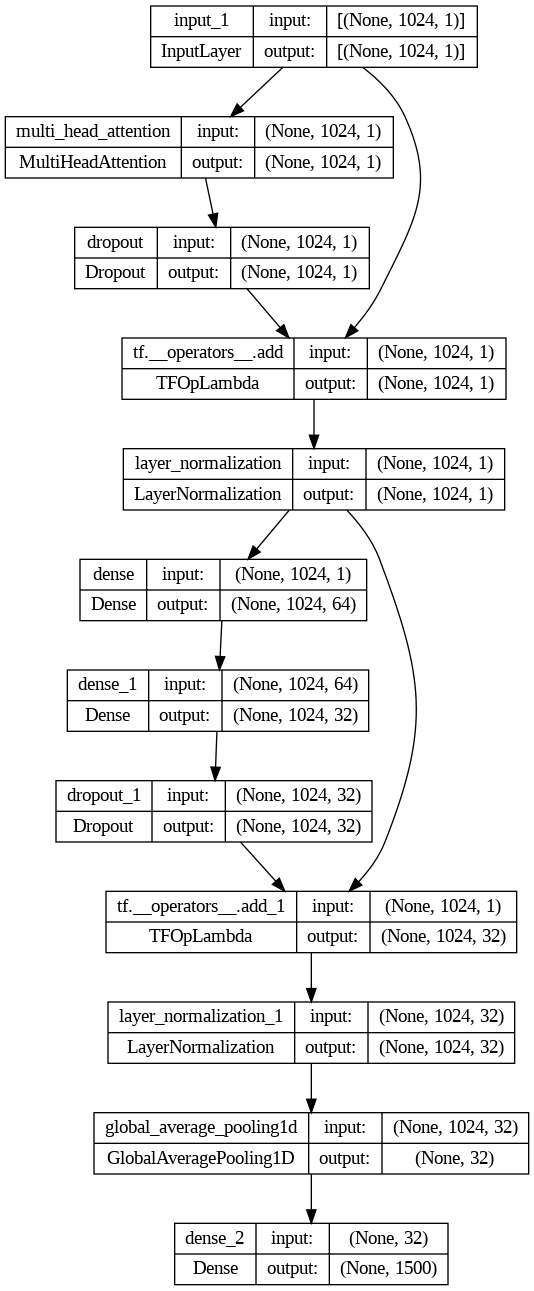

In [ ]:
from tensorflow.keras.utils import plot_model
# Visualiser l'architecture
plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image(filename='model_structure.png')


# **Transformer with Grid Search**

In [ ]:
# Constants
NUM_LABELS = 1500
BATCH_SIZE = 32
EPOCHS = 6

# Define the Transformer Encoder Layer
def transformer_encoder(inputs, embed_dim, num_heads, ff_dim, rate=0.1):
    # Multi-head attention
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
    attention_output = Dropout(rate)(attention_output)
    attention_output = LayerNormalization(epsilon=1e-6)(inputs + attention_output)

    # Feed forward network
    ffn_output = Dense(ff_dim, activation="relu")(attention_output)
    ffn_output = Dense(embed_dim)(ffn_output)
    ffn_output = Dropout(rate)(ffn_output)
    ffn_output = LayerNormalization(epsilon=1e-6)(attention_output + ffn_output)
    return ffn_output

# Function to create the Transformer model
def build_transformer(embed_dim, num_heads, ff_dim, rate):
    inputs = Input(shape=(1024, 1))
    x = transformer_encoder(inputs, embed_dim, num_heads, ff_dim, rate)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = Dense(NUM_LABELS, activation="sigmoid")(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["binary_accuracy"])
    return model

# Function to evaluate the model
def evaluate_transformer_model(model, X_test, y_test):
  # Convertir les DataFrames en numpy arrays si nécessaire
    if isinstance(X_test, pd.DataFrame):
        X_test = X_test.values
    if isinstance(y_test, pd.DataFrame):
        y_test = y_test.values

    y_pred_probs = model.predict(X_test)
    precisions, recalls, thresholds = precision_recall_curve(y_test.ravel(), y_pred_probs.ravel())
    f1_scores = 2 * (precisions * recalls) / (np.maximum(precisions + recalls, 1e-5))
    fmax = np.max(f1_scores)
    aupr = auc(recalls, precisions)
    return fmax, aupr

# Hyperparameters grid
param_grid = {
    'embed_dim': [32, 64],
    'num_heads': [2, 4],
    'ff_dim': [64, 128],
    'rate': [0.1, 0.2],
}

# Manual grid search implementation
best_score = 0
best_params = {}

for embed_dim in param_grid['embed_dim']:
    for num_heads in param_grid['num_heads']:
        for ff_dim in param_grid['ff_dim']:
            for rate in param_grid['rate']:
                print(f"Testing model with embed_dim={embed_dim}, num_heads={num_heads}, ff_dim={ff_dim}, rate={rate}")
                model = build_transformer(embed_dim, num_heads, ff_dim, rate)
                model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_val, y_val))
                fmax, aupr = evaluate_transformer_model(model, X_test, y_test)
                print(f"Fmax: {fmax}, AUPR: {aupr}")

                # Check if the current model is better
                if fmax > best_score:
                    best_score = fmax
                    best_params = {'embed_dim': embed_dim, 'num_heads': num_heads, 'ff_dim': ff_dim, 'rate': rate}
                    # Save the best model
                    model.save("/content/drive/MyDrive/model_checkpoints/transformer_best_model.h5")

print("Best Fmax:", best_score)
print("Best Parameters:", best_params)

Testing model with embed_dim=32, num_heads=2, ff_dim=64, rate=0.1
Epoch 1/6
3557/3557 [==============================] - 136s 37ms/step - loss: 0.0848 - binary_accuracy: 0.9792 - val_loss: 0.0782 - val_binary_accuracy: 0.9799
Epoch 2/6
3557/3557 [==============================] - 131s 37ms/step - loss: 0.0782 - binary_accuracy: 0.9799 - val_loss: 0.0783 - val_binary_accuracy: 0.9799
Epoch 3/6
3557/3557 [==============================] - 131s 37ms/step - loss: 0.0782 - binary_accuracy: 0.9799 - val_loss: 0.0782 - val_binary_accuracy: 0.9799
Epoch 4/6
3557/3557 [==============================] - 131s 37ms/step - loss: 0.0782 - binary_accuracy: 0.9799 - val_loss: 0.0783 - val_binary_accuracy: 0.9799
Epoch 5/6
3557/3557 [==============================] - 131s 37ms/step - loss: 0.0782 - binary_accuracy: 0.9799 - val_loss: 0.0783 - val_binary_accuracy: 0.9800
Epoch 6/6
445/445 [==============================] - 7s 14ms/step
Fmax: 0.3119850995666166, AUPR: 0.239612261258014
Testing model with

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/6
3557/3557 [==============================] - 135s 37ms/step - loss: 0.0852 - binary_accuracy: 0.9792 - val_loss: 0.0786 - val_binary_accuracy: 0.9799
Epoch 2/6
3557/3557 [==============================] - 132s 37ms/step - loss: 0.0782 - binary_accuracy: 0.9799 - val_loss: 0.0788 - val_binary_accuracy: 0.9799
Epoch 3/6
3557/3557 [==============================] - 132s 37ms/step - loss: 0.0782 - binary_accuracy: 0.9799 - val_loss: 0.0788 - val_binary_accuracy: 0.9799
Epoch 4/6
3557/3557 [==============================] - 132s 37ms/step - loss: 0.0782 - binary_accuracy: 0.9799 - val_loss: 0.0786 - val_binary_accuracy: 0.9799
Epoch 5/6
3557/3557 [==============================] - 132s 37ms/step - loss: 0.0782 - binary_accuracy: 0.9799 - val_loss: 0.0791 - val_binary_accuracy: 0.9799
Epoch 6/6
445/445 [==============================] - 7s 14ms/step
Fmax: 0.3120113386712823, AUPR: 0.2400382996645629


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Testing model with embed_dim=32, num_heads=2, ff_dim=128, rate=0.1
Epoch 1/6
3557/3557 [==============================] - 137s 38ms/step - loss: 0.0849 - binary_accuracy: 0.9793 - val_loss: 0.0781 - val_binary_accuracy: 0.9799
Epoch 2/6
3557/3557 [==============================] - 134s 38ms/step - loss: 0.0782 - binary_accuracy: 0.9799 - val_loss: 0.0782 - val_binary_accuracy: 0.9800
Epoch 3/6
3557/3557 [==============================] - 134s 38ms/step - loss: 0.0782 - binary_accuracy: 0.9799 - val_loss: 0.0784 - val_binary_accuracy: 0.9800
Epoch 4/6
3557/3557 [==============================] - 134s 38ms/step - loss: 0.0782 - binary_accuracy: 0.9799 - val_loss: 0.0782 - val_binary_accuracy: 0.9799
Epoch 5/6
3557/3557 [==============================] - 134s 38ms/step - loss: 0.0782 - binary_accuracy: 0.9799 - val_loss: 0.0782 - val_binary_accuracy: 0.9799
Epoch 6/6
445/445 [==============================] - 7s 15ms/step
Fmax: 0.3120113386712823, AUPR: 0.24018808571208697
Testing model w

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Testing model with embed_dim=32, num_heads=4, ff_dim=64, rate=0.1


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.